In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models, transforms
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader # Import TensorDataset and DataLoader
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
drive.mount('/content/drive',force_remount=True)
wd = "/content/drive/MyDrive/project"
os.chdir(wd)

Mounted at /content/drive


In [3]:
# Load data
train_images, train_labels = torch.load('train_preprocessed.pt')
val_images, val_labels = torch.load('val_preprocessed.pt')
test_images, test_labels = torch.load('test_preprocessed.pt')

In [4]:
train_images.requires_grad_(True)
#train_labels.requires_grad_(True)
val_images.requires_grad_(True)
#val_labels.requires_grad_(True)
test_images.requires_grad_(True)
#test_labels.requires_grad_(True)

tensor([[[[-0.4739, -0.4397, -0.4226,  ...,  1.5125,  1.5639,  1.5810],
          [-0.4226, -0.4054, -0.4226,  ...,  1.5297,  1.5468,  1.5468],
          [-0.4054, -0.4054, -0.3883,  ...,  1.5297,  1.4954,  1.5125],
          ...,
          [ 0.7591,  0.7419,  0.7762,  ...,  0.8104,  0.7762,  0.7591],
          [ 0.7762,  0.8276,  0.7933,  ...,  0.8447,  0.8618,  0.8276],
          [ 0.8104,  0.8789,  0.8447,  ...,  0.8104,  0.8104,  0.8104]],

         [[-0.3550, -0.3200, -0.3025,  ...,  1.6758,  1.7283,  1.7458],
          [-0.3025, -0.2850, -0.3025,  ...,  1.6933,  1.7108,  1.7108],
          [-0.2850, -0.2850, -0.2675,  ...,  1.6933,  1.6583,  1.6758],
          ...,
          [ 0.9230,  0.9055,  0.9405,  ...,  0.9055,  0.8704,  0.8529],
          [ 0.9405,  0.9930,  0.9580,  ...,  0.9405,  0.9580,  0.9230],
          [ 0.9755,  1.0455,  1.0105,  ...,  0.9055,  0.9230,  0.9405]],

         [[-0.2707, -0.2358, -0.2184,  ...,  1.8905,  1.9428,  1.9603],
          [-0.2184, -0.2010, -

In [5]:
# Create Dataset objects
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

In [6]:
# Model
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

num_ftrs = model.classifier[1].in_features
num_classes = len(torch.unique(train_labels))
# Fine tuning layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
"""model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(512, num_classes)
)"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 131MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# Dataloaders

batch_size = 32  # or whatever batch size you prefer

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Set up optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)#, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)

In [9]:
# Freeze all layers except last
for param in model.parameters():
  param.requires_grad = False
for param in model.classifier.parameters():
  param.requires_grad = True

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

start = time.time()
num_epochs = 50  # Adjust as needed

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

scheduler = CosineAnnealingLR(optimizer, T_max=50)  # T_max = number of epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)


for epoch in range(num_epochs):
    # Training loop
    model.train()
    #print(f'Epoch {epoch+1}/{num_epochs}')
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation loop with detailed metrics
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {epoch_loss:.4f} - '
          f'Val Loss: {epoch_val_loss:.4f} - '
          f'Val Accuracy: {val_accuracy:.2f}%'
          f'Epoch time:', time.time() - start)


    # Update learning rate scheduler
    scheduler.step()

KeyboardInterrupt: 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            try:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

                pbar.set_postfix({"Train Loss": loss.item()})
            except RuntimeError as e:
                print("⚠️ Skipping batch due to error:", e)
                torch.cuda.empty_cache()
                continue

        if scheduler:
            scheduler.step()

        avg_train_loss = train_loss / train_total
        train_accuracy = 100. * train_correct / train_total

        # ===== Validation =====
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_accuracy = 100. * val_correct / val_total

        print(f"\n✅ Epoch [{epoch+1}/{num_epochs}] done in {time.time() - start_time:.2f}s")
        print(f"   Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"   Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_accuracy:.2f}%\n")

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


<ipython-input-11-0355b816eaf9>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch [1/50]:   0%|          | 0/119 [00:00<?, ?it/s]<ipython-input-11-0355b816eaf9>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1/50]:   3%|▎         | 4/119 [00:56<27:01, 14.10s/it, Train Loss=1.72]

In [ ]:
torch.save(model.state_dict(), 'efficientnetV2_model.pth')


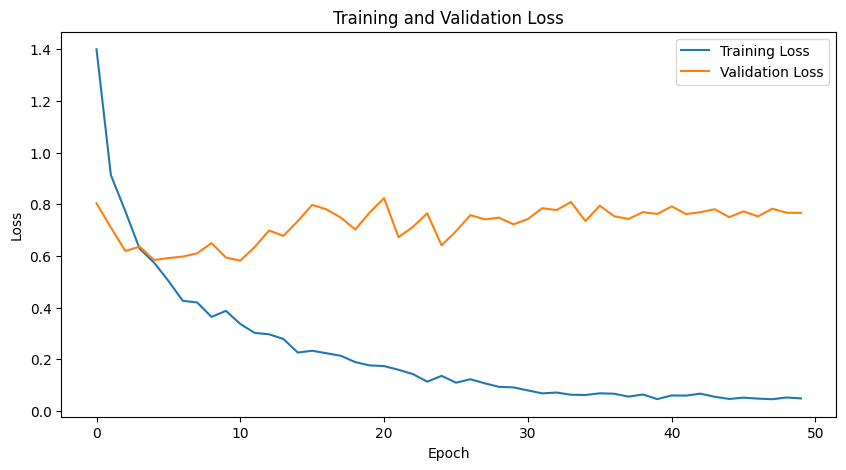

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculations during inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 82.77%


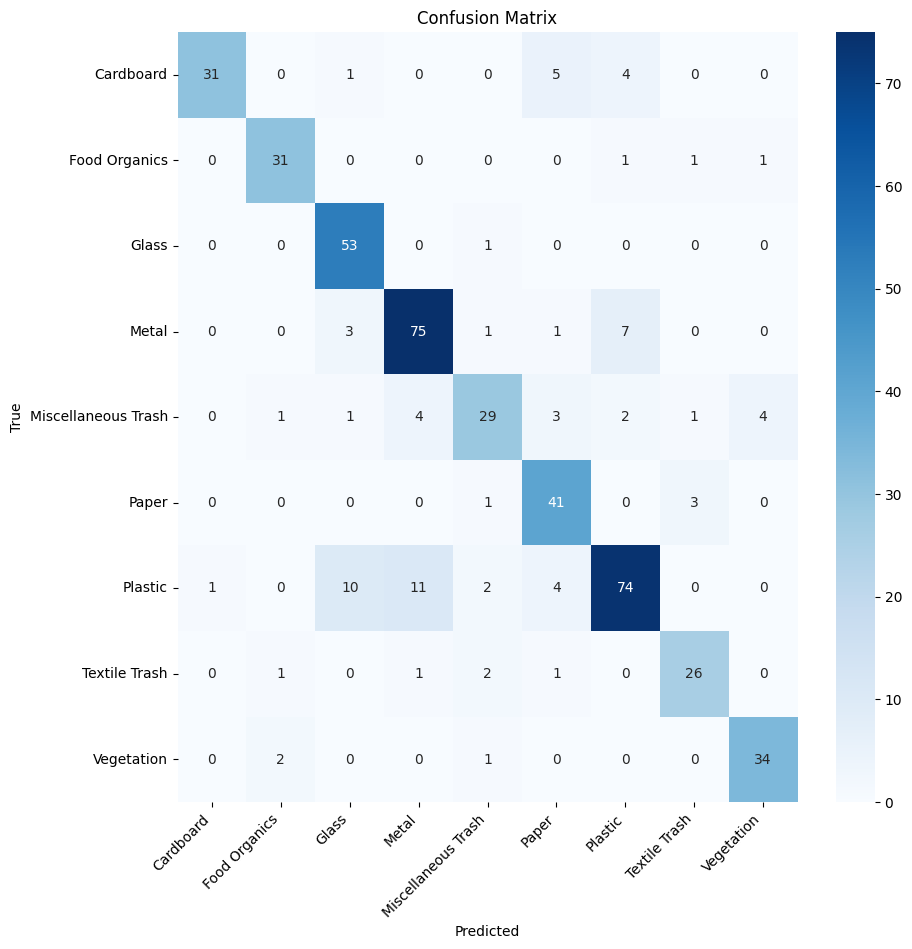

In [ ]:

labels = {0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}

all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and plot confusion matrix with labels
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[labels[i] for i in range(len(labels))],
            yticklabels=[labels[i] for i in range(len(labels))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
